# Linear Regression

Welcome to the introduction to the regression section of the Machine Learning with Python tutorial series. By this point, you should have Scikit-Learn already installed. If not, get it, along with Pandas and matplotlib!
If you have a pre-compiled scientific distribution of Python like ActivePython from our sponsor, you should already have numpy, scipy, scikit-learn, matplotlib, and pandas installed. If not, do:


In [ ]:
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

Along with those tutorial-wide imports, we're also going to be making use of Quandl here, which you may need to separately install, with:


In [7]:
!pip install quandl

    100% |████████████████████████████████| 71kB 584kB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 968kB/s ta 0:00:011
  Running setup.py bdist_wheel for inflection ... done
  Stored in directory: /home/ibrahim/.cache/pip/wheels/41/fa/e9/2995f4ab121e9f30f342fa2d43f0b27f851a0cb9f0d98d3b45
Successfully built inflection


To begin, what is regression in terms of us using it with machine learning? The goal is to take continuous data, find the equation that best fits the data, and be able forecast out a specific value. With simple linear regression, you are just simply doing this by creating a best fit line:

![First Decision Trees](https://pythonprogramming.net/static/images/machine-learning/linear-regression-algorithm-tutorial-test.png)

In [31]:
import pandas as pd
import quandl
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

df = quandl.get('WIKI/GOOGL')
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

Thus, not all of the data you have is useful, and sometimes you need to do further manipulation on your data to make it even more valuable before feeding it through a machine learning algorithm. Let's go ahead and transform our data next.
We will create a new column that is the % spread based on the closing price, which is our crude measure of volatility. Next, we'll do daily percent change then we will define a new dataframe with *Adj. Close*, *HL_Pct* , *PCT_Change* , *Adj. Volume* as columns

In [32]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume',]]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close'])/df['Adj. Close']* 100.0
df['PCT_CHANGE'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Close']* 100.0
df = df[['Adj. Close','HL_PCT','PCT_CHANGE','Adj. Volume',]]

In [33]:
#printing the dataframe's header
print(df.head())

            Adj. Close    HL_PCT  PCT_CHANGE  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.323915   44659000.0
2004-08-20   54.322689  0.710922    6.739913   22834300.0
2004-08-23   54.869377  3.729433   -1.243144   18256100.0
2004-08-24   52.597363  6.417469   -6.074187   15247300.0
2004-08-25   53.164113  1.886792    1.169811    9188600.0


In our case, what are the features and what is the label? We're trying to predict the price, so is price the label? If so, what are the featuers? When it comes to forecasting out the price, our label, the thing we're hoping to predict, is actually the future price. As such, our features are actually: current price, high minus low percent, and the percent change volatility. The price that is the label shall be the price at some determined point the future. Let's go ahead and add a few new rows.
Now we will define the forecasting column, then we fill any NaN data with -99999. You have a few choice here regarding how to handle missing data. You can't just pass a NaN (Not a Number) datapoint to a machine learning classifier, you have to handle for it. One popular option is to replace missing data with -99,999. With many machine learning classifiers, this will just be recognized and treated as an outlier feature. You can also just drop all feature/label sets that contain missing data, but then you're maybe leaving a lot of data out.

In [34]:
forecast_col = 'Adj. Close'
df.fillna(-9999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))

Finally, we define what we want to forecast out. In many cases, such as in the case of trying to predict a client's premium for insurance, you just want one number, for the "right now", but, with forecasting, you want to forecast out a certain number of datapoints. We're saying we want to forecast out 1% of the entire length of the dataset. Thus, if our data is 100 days of stock prices, we want to be able to predict the price 1 day out into the future. Choose whatever you like. If you are just trying to predict tomorrow's price, then you would just do 1 day out, and the forecast would be just one day out. If you predict 10 days out, we can actually generate a forcast for every day, for the next week and a half.

In our case, we've decided the features are a bunch of the current values, and the label shall be the price, in the future, where the future is 1% of the entire length of the dataset out. We'll assume all current columns are our features, so we'll add a new column with a simple pandas operation:

In [35]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [36]:
X = np.array(df.drop(['label'], 1))

''''We could leave it at this, and move on to training and testing, 
but we're going to do some pre-processing. Generally, you want your 
features in machine learning to be in a range of -1 to 1. This may 
do nothing, but it usually speeds up processing and can also help 
with accuracy. Because this range is so popularly used, it is 
included in the preprocessing module of Scikit-Learn. 
To utilize this, you can apply preprocessing.scale to your X variable'''

X = preprocessing.scale(X)
X = X[:-forecast_out]
#Drop any na information from the data frame
df.dropna(inplace=True)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [37]:
clf = LinearRegression()
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.978478009146


With that in mind, let's handle all of the rows from the definition of X onward:

In [38]:
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)

In [39]:
forecast_set = clf.predict(X_lately)

The forecast_set is an array of forecasts, showing that not only could you just seek out a single prediction, but you can seek out many at once. To see what we have thus far:

In [52]:
print(forecast_set, accuracy, forecast_out)

[ 1021.04208709  1024.56598109  1002.87084843  1008.1623113   1010.88297566
  1009.30416572  1049.24844847  1052.32121511  1052.33961619  1062.0950729
  1063.07635317  1070.32003709  1062.09186316  1072.77401113  1067.66723217
  1064.38207322  1060.81656686  1062.02245408  1056.4770923   1068.53379725
  1054.54576664  1054.64652074  1070.76822154  1072.18594542  1076.79124166
  1092.39235029  1081.95387673  1054.91016884  1055.32134265  1043.70553238
  1029.52975196  1037.45024472  1052.0613469   1064.38042454] 0.978478009146 34


So these are our forecasts out. Now what? Well, you are basically done, but we can work on visualizing this information. So stock prices are daily, for 5 days, and then there are no prices on the weekends. I recognize this fact, but we're going to keep things simple, and plot each forecast as if it is simply 1 day out. If you want to try to work in the weekend gaps (don't forget holidays) go for it, but we'll keep it simple. To start, we'll add a couple new imports:

In [41]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

In [42]:
style.use('ggplot')
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [43]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

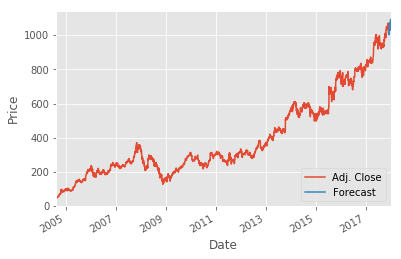

In [44]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

I remember the first time that I was trying to learn about machine learning, and most examples were only covering up to the training and testing part, totally skipping the prediction part. Of the tutorials that did the training, testing, and predicting part, I did not find a single one that explained saving the algorithm. With examples, data is generally pretty small overall, so the training, testing, and prediction process is relatively fast. In the real world, however, data is likely to be larger, and take much longer for processing. Since no one really talked about this important stage, I wanted to definitely include some information on processing time and saving your algorithm.

While our machine learning classifier takes a few seconds to train, there may be cases where it takes hours or even days to train a classifier. Imagine needing to do that every day you wanted to forecast prices, or whatever. This is not necessary, as we can just save the classifier using the Pickle module. First make sure you've imported it:

In [45]:
import pickle

With pickle, you can save any Python object, like our classifier. After defining, training, and testing your classifier, add:

In [46]:
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

Now, run the script again, and boom, you should have linearregression.pickle which is the serialized data for the classifier. Now, all you need to do to use the classifier is load in the pickle, save it to clf, and use just like normal. For example:

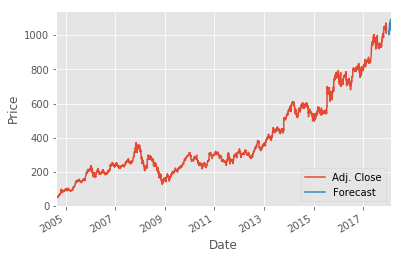

In [47]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()